# Benchmark simple operations

This is thought to show possible performance difference for simple operations performed in DBMS and Python/pandas.
This is not an exhaustive benchmark, more test are necessary for a general conclusion.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt


## Some parameters you might want to set:

In [1]:
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection

DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 10

# DBMS related:
UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [2]:
import sys
!{sys.executable} -m pip install faker

from data_generation.healthcare_data_generation import generate_healthcare_dataset

# We only generate the files, that are not already existing:
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Demo:

No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 0 - for table size of: 100
Executing Query in Umbra...
Done in 0.0001387!
Executing Query in Postgres...
Done in 0.1729!
Executing Query in Pandas...
Done in 4.489217400077905!
Executing Query in Umbra...
Done in 6.050000000000001e-05!
Executing Query in Postgres...
Done in 0.011999999999999997!
Executing Query in Pandas...
Done in 2.243644400004996!
Executing Query in Umbra...
Done in 0.00017350000000000002!
Executing Query in Postgres...
Done in 0.024000000000000004!
Executing Query in Pandas...
Done in 2.2033575998648303!
Executing Query in Umbra...
Done in 0.0004122!
Executing Query in Postgres...
Done in 0.0934!
Executing Query in Pandas...
Done in 4.646896099984588!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 1 - for table size of: 1000
Executing Query in Umbra...
Done in 0.0007072!
Executing Query in Postgres...
Done in 1.0549!
Executing Query in Pandas...
Done in 6.814396399931866!
Executing Query in Umbra...
Done in 0.00014280000000000003!
Executing Query in Postgres...
Done in 0.28630000000000005!
Executing Query in Pandas...
Done in 2.2027822000382002!
Executing Query in Umbra...
Done in 0.0001268!
Executing Query in Postgres...
Done in 0.2827!
Executing Query in Pandas...
Done in 2.452952100065886!
Executing Query in Umbra...
Done in 0.00029759999999999997!
Executing Query in Postgres...
Done in 0.541!
Executing Query in Pandas...
Done in 7.529861199873267!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 2 - for table size of: 10000
Executing Query in Umbra...
Done in 0.0033644!
Executing Query in Postgres...
Done in 5.9087000000000005!
Executing Query in Pandas...
Done in 19.639584099968488!
Executing Query in Umbra...
Done in 0.0006238999999999999!
Executing Query in Postgres...
Done in 1.4491999999999998!
Executing Query in Pandas...
Done in 5.13772140002402!
Executing Query in Umbra...
Done in 0.0003565!
Executing Query in Postgres...
Done in 1.4584000000000001!
Executing Query in Pandas...
Done in 5.992642000092019!
Executing Query in Umbra...
Done in 0.0004483!
Executing Query in Postgres...
Done in 2.9782!
Executing Query in Pandas...
Done in 8.34934329996031!


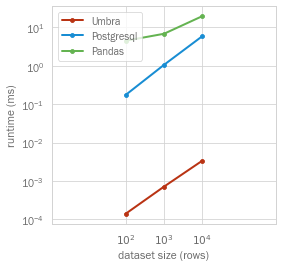

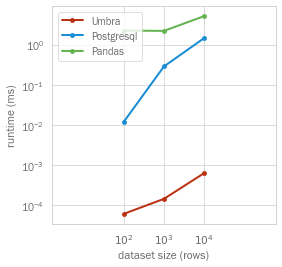

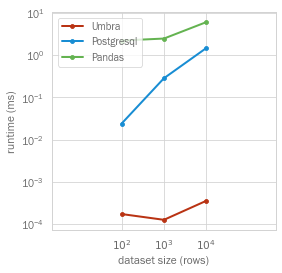

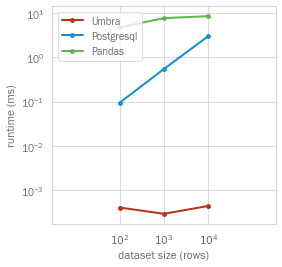

In [3]:
# Based on mlinspect benchmarks.

def simple_op_benchmark():
    t1_name = "histories"
    t2_name = "patients"

    operations = ["Join", "Select", "Project", "GroupBy"]

    umbra_times = [[] for _ in operations]
    postgres_times = [[] for _ in operations]
    pandas_times = [[] for _ in operations]

    postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                                   host="localhost")
    pandas = PandasConnector()
    repetitions = 10
    for i, (table1, table2) in enumerate(HEALTHCARE_DATA_PATHS):
        umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/",
                               umbra_dir=UMBRA_DIR)

        umbra.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
        umbra.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

        postgres.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
        postgres.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

        print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

        input_join = t1_name, t2_name, "ssn"
        umbra_times[0].append(umbra.benchmark_run(Join.get_sql_code(*input_join), repetitions))
        postgres_times[0].append(postgres.benchmark_run(Join.get_sql_code(*input_join), repetitions))
        pandas_times[0].append(
            pandas.benchmark_run(Join.get_pandas_code(table1, table2, "ssn"), repetitions=repetitions))

        input_sel = t1_name, "complications", ">", "5"
        umbra_times[1].append(umbra.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
        postgres_times[1].append(postgres.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
        pandas_times[1].append(
            pandas.benchmark_run(Selection.get_pandas_code(table1, "complications", ">", "5"),
                                 repetitions=repetitions))

        input_project = t1_name, "smoker"
        umbra_times[2].append(umbra.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
        postgres_times[2].append(postgres.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
        pandas_times[2].append(
            pandas.benchmark_run(Projection.get_pandas_code(table1, "smoker"), repetitions=repetitions))

        input_project = t1_name, "smoker", "complications", "AVG"
        umbra_times[3].append(umbra.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
        postgres_times[3].append(postgres.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
        pandas_times[3].append(
            pandas.benchmark_run(GroupBy.get_pandas_code(table1, "smoker", "complications", "mean"),
                                 repetitions=repetitions))
        # in the end we have 3 lists == [[*joins*][*selections*][*projections*]]

    names = ["Umbra", "Postgresql", "Pandas"]
    for i, title in enumerate(operations):
        table = [umbra_times[i], postgres_times[i], pandas_times[i]]
        plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)


simple_op_benchmark()

### The original results:
**Join**:

![](./plots/Join.png)

**GroupBy**:

![](./plots/GroupBy.png)

**Select**:

![](./plots/Select.png)

**Project**:

![](./plots/Project.png)

In [11]:
# Clean_up:
if DO_CLEANUP:
    [f.unlink() for f in PLOT_DIR.glob("*_.png") if f.is_file()]